In [106]:
#!/usr/bin/env python3
"""
Offset-free MPC (CT) migrated from `control/offset_free_CT.ipynb`.

- Loads A, B, C, trained Koopman-related modules, scalers, and sim setup
- Builds transformed representation with T_real
- Runs target estimation + MPC closed-loop simulation
- Saves plots under repository `figures/`
- Prints the objective line exactly as in the notebook:
  "Closed-loop objective function value: <value>"

Requires `src/helper` and `src/models` to be importable.
"""

from __future__ import annotations

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from tqdm import tqdm

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

# Add Identification directory to path for baseline_inference import
identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore




In [107]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs


In [108]:
# Import controllers module from experiments directory
experiments_path = Path.cwd().resolve().parent / 'experiments'
if str(experiments_path) not in sys.path:
    sys.path.append(str(experiments_path))

# import controllers

# # Load all necessary data and setup
# controllers.load()

# # Make loaded variables accessible in the notebook
# A = controllers.A
# B = controllers.B
# C = controllers.C
# loaded_setup = controllers.loaded_setup
# nz = controllers.nz
# nu = controllers.nu
# ny = controllers.ny
# nd = controllers.nd
# T_real = controllers.T_real
# A_block = controllers.A_block
# A_transformed = controllers.A_transformed
# A_backtransformed = controllers.A_backtransformed
# problem = controllers.problem
# scaler = controllers.scaler
# scalerU = controllers.scalerU
# y_start = controllers.y_start
# y_start_ns = controllers.y_start_ns
# reference = controllers.reference
# y_setpoint = controllers.y_setpoint
# u_previous = controllers.u_previous
# u_previous_ns = controllers.u_previous_ns
# P0 = controllers.P0
# Q = controllers.Q
# R = controllers.R
# A_ = controllers.A_
# B_ = controllers.B_
# C_ = controllers.C_
# KF = controllers.KF
# target_estimation = controllers.target_estimation
# mpc = controllers.mpc

# print("Controllers module loaded successfully!")
# print(f"Loaded matrices: A {A.shape}, B {B.shape}, C {C.shape}")
# print(f"State dimension: {nz}, Input dimension: {nu}, Output dimension: {ny}")
# print(f"Disturbance dimension: {nd}")

In [109]:
# --------------------------- Repository paths ---------------------------------

def get_repo_root() -> Path:
    # In a notebook, __file__ is not defined; use cwd as a fallback
    return Path.cwd().resolve().parent


def get_figures_dir(repo_root: Path) -> Path:
    figures = repo_root / "figures"
    figures.mkdir(parents=True, exist_ok=True)
    return figures


# # Ensure `src` is on PYTHONPATH
REPO_ROOT = get_repo_root()
SRC_PATH = REPO_ROOT / 'src'
if SRC_PATH.as_posix() not in sys.path:
    sys.path.append(SRC_PATH.as_posix())

import helper  # type: ignore
import models  # type: ignore


# # ------------------------------ IO utilities ----------------------------------






# def load_scalers(data_dir: Path):
#     scaler = joblib.load((data_dir / 'scaler.pkl').as_posix())
#     scalerU = joblib.load((data_dir / 'scalerU.pkl').as_posix())
#     return scaler, scalerU



# ------------------------------ CT helpers ------------------------------------

def build_encoders_decoders(ny: int, nz: int, nu: int, matrix_C: bool):
    cons = 1
    layers = [6*cons,12*cons,18*cons]
    layers_dec  = [18*cons,12*cons,6*cons]

    # output encoder f_y
    f_y = blocks.MLP(
        ny,
        nz,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ReLU,
        hsizes=layers,
    )
    encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
    encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

    # input encoder f_u representing B
    f_u = torch.nn.Linear(nu, nz, bias=False)
    encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

    # decoder
    if not matrix_C:
        f_y_inv = blocks.MLP(
            nz, ny, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU, hsizes=layers_dec
        )
    elif matrix_C:
        f_y_inv = torch.nn.Linear(nz, ny, bias=False)
    else:
        raise ValueError('matrix_C must be boolean')
    decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

    # Koopman linear K
    K = torch.nn.Linear(nz, nz, bias=False)
    Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')

    dynamics_model = System([Koopman], name='Koopman', nsteps=1)
    nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
    loss = PenaltyLoss([], constraints=[])
    problem = Problem(nodes, loss)
    return problem


def get_x_from_y(problem, y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1, -1).T


def get_y_from_x(problem, x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1, -1)





In [110]:
data_dir = REPO_ROOT / '../data'
figures_dir = get_figures_dir(REPO_ROOT)

# Load matrices for matrix_C=False as in notebook
matrix_C = True
A = np.load(f"../data/A_C_{matrix_C}.npy")
B = np.load(f"../data/B_C_{matrix_C}.npy")
C = np.load(f"../data/C_C_{matrix_C}.npy")

nz, nu = B.shape
ny = C.shape[0]

# Disturbance model dimension
F = np.eye(ny)
nd = F.shape[1]

# # Resample A and B from Ts=1 to Ts=10 seconds
# Ts_old = 1.0    # original timestep in seconds
# Ts_new = 10.0   # desired timestep in seconds

# # Assume system is already in discrete time with Ts=1.0
# # To resample A, B to Ts=10.0, use the method for "resampling" discrete systems:
# #   A_10 = A_1^10
# #   B_10 = sum_{i=0}^{9} A_1^i @ B_1

# import scipy.linalg as la

# # Convert to continuous through matrix log
# Ac = la.logm(A) / Ts_old
# Bc = np.linalg.solve(Ac, (A - np.eye(A.shape[0]))) @ B

# # Re-discretize at Ts_new
# A = A_10 = la.expm(Ac * Ts_new)
# B = B_10 = np.linalg.solve(Ac, (A_10 - np.eye(A.shape[0]))) @ Bc
# print(np.max(A.imag))
# A = np.real(A)  # or use np.real(A_10) if you're sure
# B = np.real(B)

# # A_10 = np.linalg.matrix_power(A, int(Ts_new / Ts_old))

# # sum_term = np.zeros_like(B)
# # A_power = np.eye(A.shape[0])
# # for i in range(int(Ts_new / Ts_old)):
# #     sum_term += A_power @ B
# #     A_power = A @ A_power
# # B_10 = sum_term

# # A = A_10
# # B = B_10

# np.save(f"../data/A_C_{matrix_C}_Ts.npy", A)
# np.save(f"../data/B_C_{matrix_C}_Ts.npy", B)



# Block diagonalization
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print("Close to block diagonal?", np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print("Backtransformation equals original A?", np.allclose(A, A_backtransformed, atol=1e-6))
# T_real = np.eye(nz)  # Use identity for now, as A is already block diagonal



Close to block diagonal? True
Backtransformation equals original A? True


In [111]:
data_dir

PosixPath('/Users/patrik/Documents/Research/2025-2026/offset-free-koopman-mpc/pausterization_unit/../data')

In [112]:
(data_dir / f'model_C_{matrix_C}.pth').as_posix()

'/Users/patrik/Documents/Research/2025-2026/offset-free-koopman-mpc/pausterization_unit/../data/model_C_True.pth'

In [113]:
B.shape

(18, 3)

In [114]:


# Apply transformation as in notebook (Cell 6)
A = inv(T_real) @ A @ T_real
B = inv(T_real) @ B
C = C @ T_real

# Koopman enc/dec + problem and load weights
problem = build_encoders_decoders(ny, nz, nu, matrix_C)
problem.load_state_dict(torch.load(f'../data/model_C_{matrix_C}.pth'), strict=False)

# Load scalers
scaler, scalerU = baseline_inference.scaler, baseline_inference.scalerU
# Sim setup
loaded_setup = joblib.load("sim_setup.pkl")


In [ ]:

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')
u_sp = loaded_setup['reference_u']

# Initial state estimate includes disturbance
z_est_ = np.hstack(((np.linalg.pinv(C) @ y_start.T).T, np.zeros((1, nd))))
P0 = np.eye(nz + nd)*loaded_setup['P0']
Q = np.block([
        [np.eye(nz) * 0.1,  np.zeros((nz, nd))],   # Trust state model
        [np.zeros((nd, nz)), np.eye(nd) * 1]      # Disturbance adapts slow
    ]) 
R = np.eye(ny)*0.5
Cd = np.eye(ny)
Bd = np.zeros((nz, nd))
# Cd = np.zeros((ny,nd))
# Bd = B

A_ = np.block([
    [A, Bd],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])

C_ = np.hstack([
    C, Cd,
])

KF = helper.KF(A_, B_, C_, z_est_, P0, Q, R)



In [116]:
P0.shape

(21, 21)

In [117]:
C

array([[ 3.38316143e-01,  3.93942684e-01,  2.22481385e-01,
        -5.54919019e-02,  6.62271865e-04,  2.96725519e-02,
        -1.24093786e-01, -2.92883109e-04,  9.16716978e-02,
         4.04542089e-02, -4.53388058e-02, -4.13951539e-02,
         4.10190225e-02,  6.34053424e-02,  7.21992478e-02,
        -6.40995726e-02, -1.07036084e-02, -1.17957130e-01],
       [ 4.18060243e-01, -2.68167585e-01,  8.01502243e-02,
         1.14956712e-02,  2.07257718e-01,  8.15631077e-02,
         6.62192032e-02,  2.69513577e-03, -7.79259503e-02,
         9.18698907e-02,  2.78504435e-02,  3.37797552e-01,
        -1.32881686e-01,  1.54584907e-02,  3.52029242e-02,
         1.44139260e-01,  5.53287528e-02,  1.20838135e-01],
       [ 3.04615408e-01,  1.77146822e-01, -1.49604222e-02,
         1.64182886e-01, -1.71781451e-01,  3.96662839e-02,
         1.06097572e-01,  4.28492166e-02, -1.93444684e-01,
         6.97326884e-02,  1.39939293e-01,  2.64773279e-01,
        -1.05643049e-01,  1.04020678e-01, -3.89128737e

In [118]:
z_est_[:, :]

array([[ 0.6304318 ,  1.12000564,  0.18024856,  0.24047694, -0.53956285,
         0.03705334, -0.01604414,  0.08141571, -0.18658333,  0.10019427,
         0.18990974,  0.13890772, -0.02557285,  0.2719055 , -0.01756521,
        -0.02671206, -0.1953796 , -0.00801161,  0.        ,  0.        ,
         0.        ]])

In [119]:
# Target calc
target_estimation = helper.TargetEstimation(A, B, C, loaded_setup['Qy_te'], loaded_setup['Qu_te'], Bd, Cd)
target_energy_estimation = helper.TargetEnergyEstimation(A, B, C, loaded_setup['Qe_te'], Bd, Cd)
z_s, y_s, u_s = target_estimation.get_target(z_est_[:, nz:], y_setpoint, u_sp)
z_s_energy, y_s_energy, u_s_energy = target_energy_estimation.get_target(z_est_[:, nz:], y_s, u_s)
z_ref = z_s_energy


In [120]:
y_s - y_setpoint

array([-1.95399252e-14, -7.00307641e-01, -1.59605018e-01])

In [121]:
y_s - y_s_energy

array([0.00000000e+00, 1.95733979e+00, 1.75678402e-03])

In [122]:
u_s - u_s_energy

array([ 0.        , -1.77456218,  0.3634277 ])

In [123]:
# Before calling build_problem, check Qu as well
print("Qu is PSD?", np.all(np.linalg.eigvalsh(loaded_setup['Qu']) >= -1e-10))

Qu is PSD? True


In [124]:
Qx = C.T@loaded_setup['Qy']@C + 2e-8 * np.eye(A.shape[0])



# Check if Qx is positive semi-definite
eigvals = np.linalg.eigvals(Qx)
# min_eigval = np.min(eigvals)
# if min_eigval < 0:
#     # Add enough regularization to make it PSD
#     Qx = Qx + (abs(min_eigval) + 1e-6) * np.eye(A.shape[0])

is_psd = np.all(eigvals >= 1e-8)
is_psd


np.True_

In [125]:
C @ z_est_[:, :nz].T

array([[ 0.67623007],
       [-0.06191784],
       [ 0.67019906]])

In [126]:
(C @ z_est_[:, :nz].T) >= loaded_setup['y_min'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True]])

In [127]:
(C @ z_est_[:, :nz].T) <= loaded_setup['y_max'].reshape(-1, 1)

array([[ True],
       [ True],
       [ True]])

In [128]:
# MPC problem
mpc = helper.MPC(A, B, C, loaded_setup['Qy'], loaded_setup['Qu'], loaded_setup['Qdu'], Bd, Cd)
mpc.build_problem(Qx)
_ = mpc.get_u_optimal(z_est_[:, :nz], z_est_[:, nz:], u_s_energy, u_previous, z_ref)

# mpc.Qu = np.array([[5.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]])
# Closed-loop simulation
sim_time = int(loaded_setup['sim_time'])
Ts = 1

In [129]:
y_start

array([[ 0.67623006, -0.06191781,  0.67019906]])

In [130]:
baseline_inference.get_x(y_start)

In [131]:


z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
us_sim = np.zeros((nu, sim_time))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))
us_energy_sim = np.zeros((nu, sim_time))
ys_energy_sim = np.zeros((ny, sim_time + 1))
zs_energy_sim = np.zeros((nz, sim_time + 1))

# Non-scaled histories for plant and evaluation (like NMPC)
y_sim_ns = np.zeros((ny, sim_time + 1))
u_sim_ns = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
if y_start_ns is not None:
    y_sim_ns[:, 0] = y_start_ns.flatten()
else:
    y_sim_ns[:, 0] = helper.np.asarray(scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]) if hasattr(helper, 'np') else scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
u_prev = target_energy_estimation.u_s.value

u_sim_ns[:, 0] = u_prev.flatten()

for k in tqdm(range(sim_time), desc="Closed-loop simulation", ncols=80):
    idx_prev = max(k - 1, 0)        
    # Target update
    zs_sim[:, k], ys_sim[:, k], us_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], loaded_setup["reference"][:, k], u_sp
    )
    zs_energy_sim[:, k], ys_energy_sim[:, k], us_energy_sim[:, k] = target_energy_estimation.get_target(
        z_sim[nz:, k], ys_sim[:, k], us_sim[:, k]
    )

    # # MPC
    u_opt = mpc.get_u_optimal(z_sim[:nz, k], z_sim[nz:, k], us_energy_sim[:, k], u_prev, zs_energy_sim[:, k])
    u_sim[:, k] = u_opt
    u_sim_ns[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    #function check
    # ys_sim[:, k], u_opt, us_sim[:, k] = controllers.next_optimal_input(u_prev, y_sim_ns[:,k], k)
    # u_sim_ns[:, k] = u_opt
    # u_sim[:, k] = scalerU.transform(u_opt.reshape(1, -1))[0]
    # Plant
    # for i in range(int(10-1)):
    #     baseline_inference.y_plus(u_sim[:, k])
    y_sim[:, k + 1] = baseline_inference.y_plus(u_sim[:, k])
    noise_std = 0.01  # You can adjust this value as desired
    noise = np.random.normal(0, noise_std, size=y_sim[:, k + 1].shape)
    y_sim[:, k + 1] += noise
    y_sim_ns[:, k + 1] = scaler.inverse_transform(y_sim[:, k + 1].reshape(1, -1))[0]
    # Estimation
    z_sim[:, k + 1] = KF.step(u_sim[:, k], y_sim[:, k + 1]).flatten()

    # controllers estimation
    # z_sim[:, k + 1] = controllers.KF.x.flatten()
    
    u_prev = u_sim[:, k]
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)


Closed-loop simulation: 100%|█████████████████| 500/500 [00:47<00:00, 10.58it/s]


Closed-loop objective function value: 486.77221741093473
  - State tracking term: 438.72044038516117
  - Input increment term: 31.70709570296072
  - Input setpoint term: 16.344681322812228
Closed-loop objective function value: 387.4645219131715
  - State tracking term: 371.6881510629894
  - Input setpoint term: 15.770190436183988


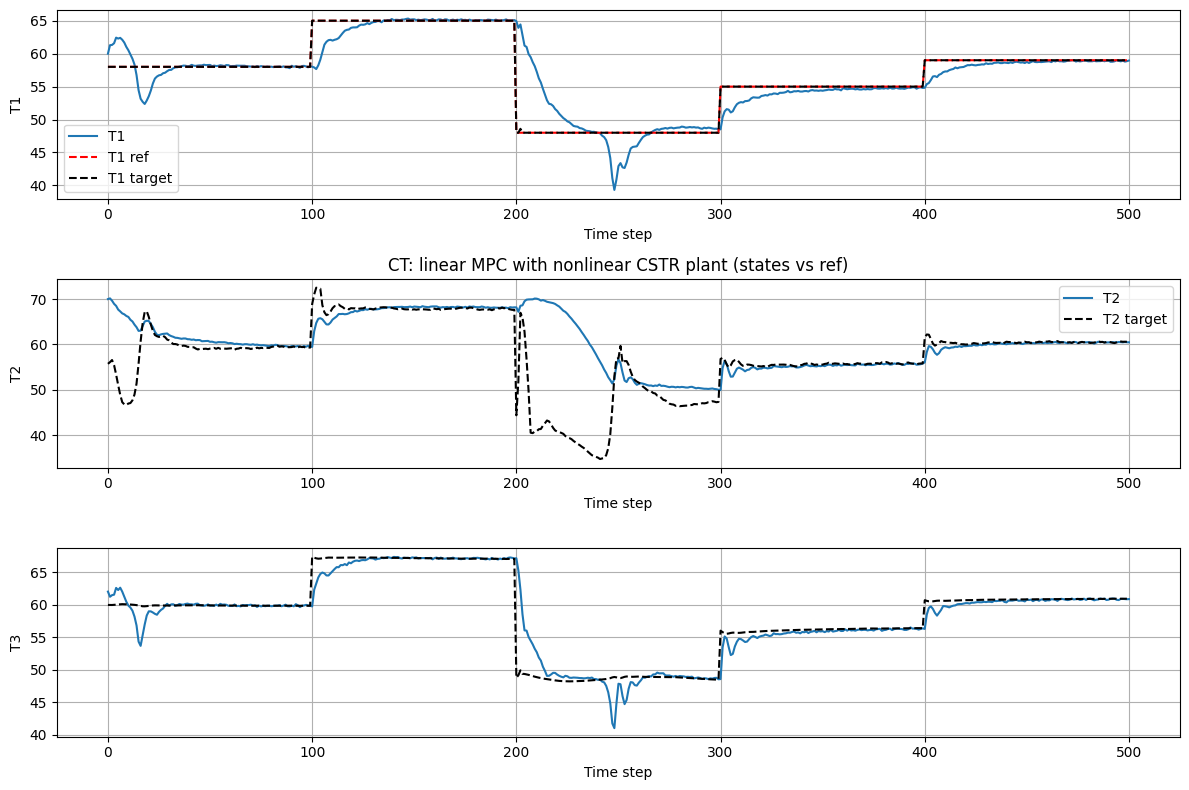

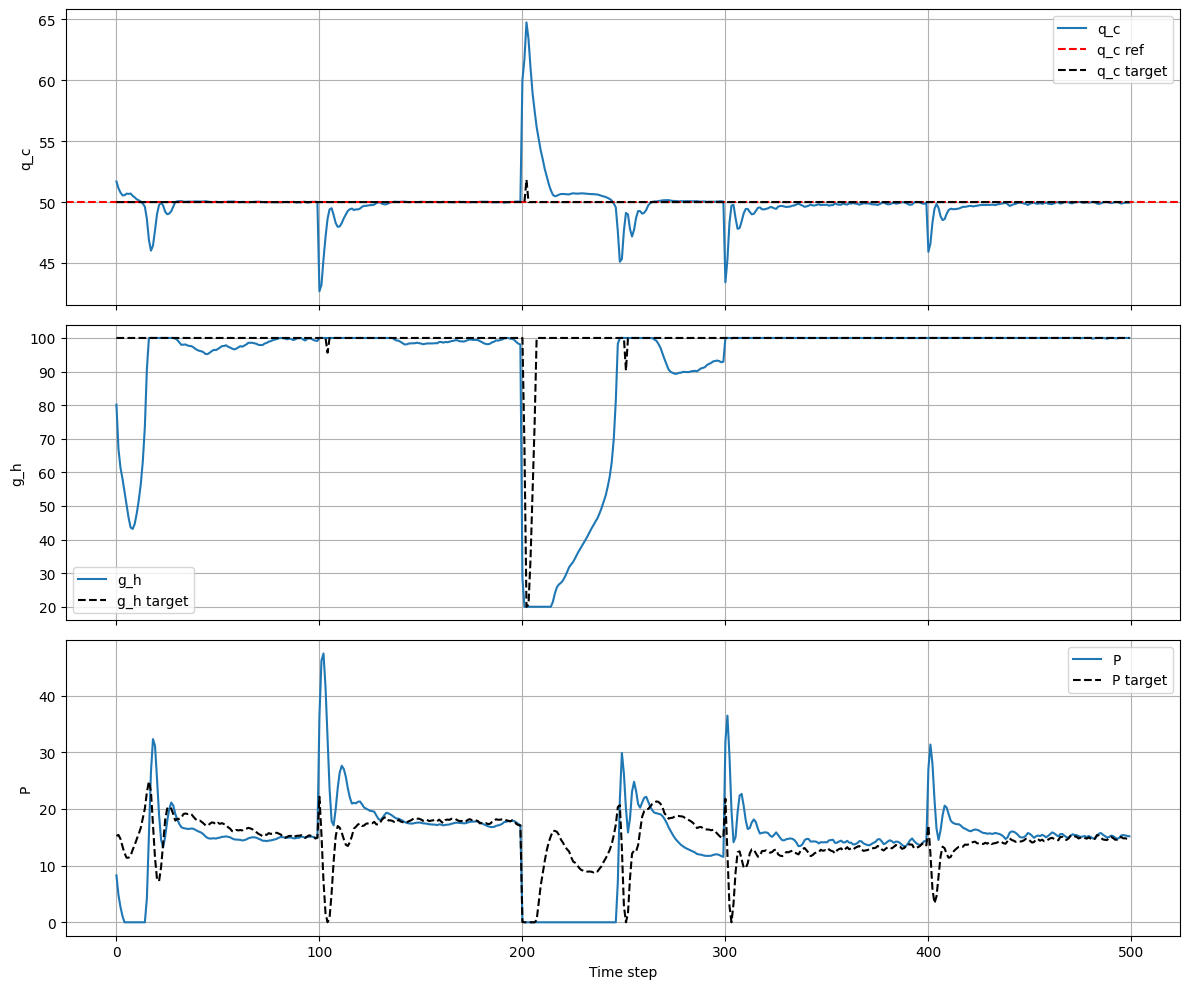

In [132]:
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
Qdu = loaded_setup['Qdu']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
control_setpoint_cost = 0.0
for k in range(sim_time):
    y_ref_k = ys_energy_sim[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    u_error = u_sp - u_sim[:, k]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qdu @ u_diff)
    u_sp_term = float(u_error.T @ Qu @ u_error)
    state_error_cost += y_term
    control_increment_cost += u_term
    control_setpoint_cost += u_sp_term
    objective_value += y_term + u_term + u_sp_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")
print(f"  - Input setpoint term: {control_setpoint_cost}")


Qu = loaded_setup['Qu_te']
Qy = loaded_setup['Qy_te']
objective_value = 0.0
state_error_cost = 0.0
control_setpoint_cost = 0.0
for k in range(sim_time):
    y_ref_k = loaded_setup['reference'][:, k]
    y_diff = y_sim[:, k] - y_ref_k
    u_error = us_energy_sim[:, k] - u_sim[:, k]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_sp_term = float(u_error.T @ Qu @ u_error)
    state_error_cost += y_term
    control_setpoint_cost += u_sp_term
    objective_value += y_term + u_term + u_sp_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input setpoint term: {control_setpoint_cost}")



# Plots saved to figures/ in non-scaled domain (8 states, 4 inputs)
ys_sim_ns = scaler.inverse_transform(ys_energy_sim.T).T
# ys_sim_ns = ys_sim
zs_sim_ns = scaler.inverse_transform((C@zs_energy_sim + z_sim[nz:]).T).T
z_sim_ns = scaler.inverse_transform((C@z_sim[:nz]).T).T
us_sim_ns = scalerU.inverse_transform(us_energy_sim.T).T
# us_sim_ns = us_sim

names = ['T1','T2','T3']
n_steps = sim_time
fig, axs = plt.subplots(nrows=min(8, ny), ncols=1, figsize=(12, 8))
if min(8, ny) == 1:
    axs = [axs]  # Ensure axs is always iterable
for i in range(min(8, ny)):
    ax = axs[i]
    # Actual output
    ax.plot(y_sim_ns[i, :], label=names[i] if i < len(names) else f'y{i}')
    # Reference trajectory
    if i == 0:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    # Target/Estimated reference
    ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    # State estimate (plot on top)
    # ax.plot(z[i, :n_steps], 'g:', label=f'{names[i]} est' if i < len(names) else f'y{i} est')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0,1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()
# fig.savefig((figures_dir / 'CT_states.png').as_posix(), dpi=200)


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'g_h', 'P']
for i in range(len(input_names)):
    axs[i].plot(u_sim_ns[i, :], label=input_names[i])
    if i == 0:
        axs[i].axhline(scalerU.inverse_transform(u_sp.reshape(1, -1))[0][i], color='r', linestyle='--',
                       label=f'{input_names[i]} ref')
    axs[i].plot(us_sim_ns[i, :], 'k--', label=f"{input_names[i]} target")
    
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#522

In [133]:
sum(u_sim_ns[2,:])

np.float64(7383.798070690031)

In [134]:
sum(sum(z_sim[nz:,:]))

np.float64(811.1654467508822)

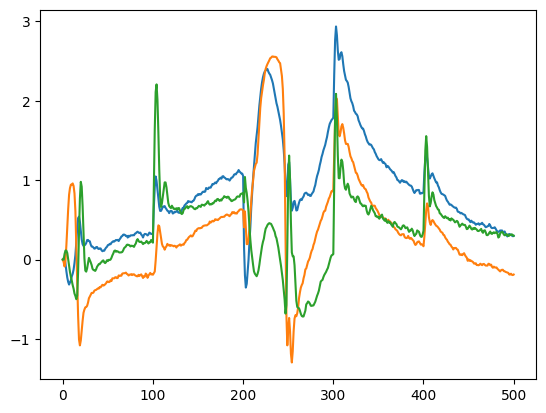

In [135]:
plt.plot(z_sim[nz:,:].T)

In [136]:
C@z_sim[:nz] + z_sim[nz:]

array([[ 0.67623007,  0.66170376,  0.83430161, ...,  0.81869081,
         0.81379288,  0.82130839],
       [-0.06191784,  0.0157773 ,  0.04145124, ..., -1.60066154,
        -1.60409647, -1.59860456],
       [ 0.67019906,  0.49765306,  0.71058632, ...,  0.84000363,
         0.83022989,  0.82164803]])

In [137]:
scaler.inverse_transform((C@z_sim[:nz] + z_sim[nz:]).T).T

array([[60.00000011, 59.89789997, 61.11102699, ..., 61.00130444,
        60.96687868, 61.01970246],
       [69.99999973, 70.54724187, 70.72807508, ..., 59.16193019,
        59.13773641, 59.17641839],
       [62.00000004, 60.66185243, 62.31321575, ..., 63.31688702,
        63.24108865, 63.17453367]])

In [138]:
scaler.mean_

array([55.24702672, 70.43611518, 56.80239899])

## Fast Test: Observer Open-Loop with Constant Bias

Test the observer's ability to track a constant bias in open-loop (or with fixed stabilizing control).

FAST TEST 1: Observer Open-Loop with True Model Mismatch

Using CT_10 model with matrix_C = True
  Model dimensions: nz=18, nu=3, ny=3, nd=3
  A matrix shape: (18, 18)
  B matrix shape: (18, 3)
  C matrix shape: (3, 18)

Calculating true disturbance from steady-state mismatch...
  (Using CT_10 Koopman model: A_C_True.npy, B_C_True.npy, C_C_True.npy)
  Finding baseline plant steady state (u=0)...
Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs
  Baseline steady state (u=0): [0.70515513 0.54864836 0.4970407 ]
  Finding Koopman model steady state (u=0)...
  Koopman steady state (u=0):  [0. 0. 0.]

  TRUE DISTURBANCE (model mismatch): [0.70515513 0.54864836 0.49704069]

Test setup:
  Koopman state from main sim: [-1.75059684  3.7069521  -1.02485205]...
  True disturbance (ss mismatch): [0.70515513 0.54864836 0.49704069]
  Fixed control input: [-0.51592284  0.20263648 -0.15227118]

Running 200 steps with Koopman mode

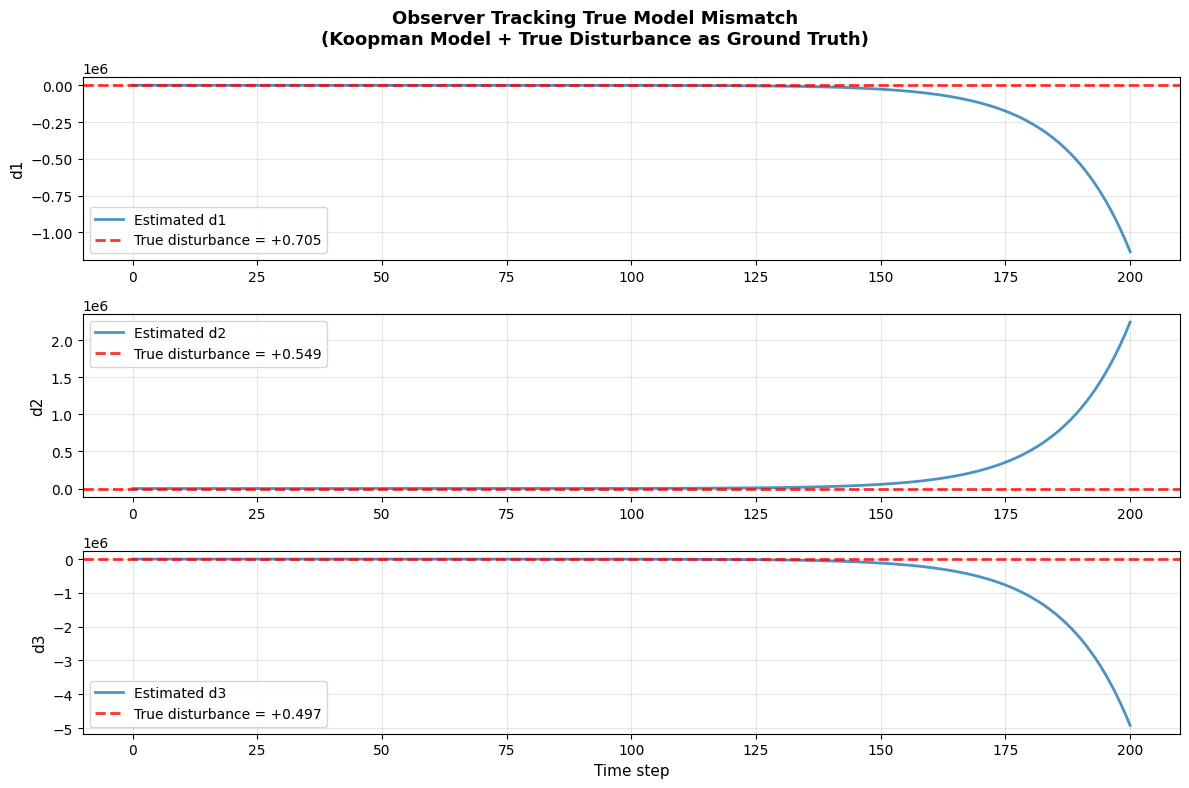


Output comparison:
True output (Koopman + true dist): [ -408543.01861271 -4378569.27996314  -678397.35126248]
Koopman + estimated disturbance:   [-1592388.12837392 -1925443.38786495 -5619345.71375183]
Prediction error:                  [1183845.10976121 2453125.89209819 4940948.36248935]

Test 1 completed successfully!


In [139]:
# Fast test 1: Observer tracking constant bias (model mismatch)
print("="*60)
print("FAST TEST 1: Observer Open-Loop with True Model Mismatch")
print("="*60)

# Verify which model is being used
print(f"\nUsing CT_10 model with matrix_C = True")
print(f"  Model dimensions: nz={nz}, nu={nu}, ny={ny}, nd={nd}")
print(f"  A matrix shape: {A.shape}")
print(f"  B matrix shape: {B.shape}")
print(f"  C matrix shape: {C.shape}")

# ==============================================================================
# Calculate TRUE disturbance: steady-state mismatch between baseline and Koopman
# ==============================================================================
print("\nCalculating true disturbance from steady-state mismatch...")
print("  (Using CT_10 Koopman model: A_C_True.npy, B_C_True.npy, C_C_True.npy)")

# Zero input
u_zero = np.zeros(nu)

# Baseline plant: find steady-state output with zero input
print("  Finding baseline plant steady state (u=0)...")
baseline_inference.init()  # Reset baseline
n_ss_steps = 5000  # Steps to reach steady state
for _ in range(n_ss_steps):
    y_baseline_ss = baseline_inference.y_plus(u_zero)

print(f"  Baseline steady state (u=0): {y_baseline_ss}")

# Koopman model: steady-state with zero input
print("  Finding Koopman model steady state (u=0)...")
z_koopman_ss = np.zeros(nz)
for _ in range(n_ss_steps):
    z_koopman_ss = A @ z_koopman_ss + B @ u_zero
y_koopman_ss = C @ z_koopman_ss

print(f"  Koopman steady state (u=0):  {y_koopman_ss}")

# TRUE DISTURBANCE = baseline output - Koopman output (at zero input steady state)
true_disturbance_test1 = y_baseline_ss - y_koopman_ss

print(f"\n  TRUE DISTURBANCE (model mismatch): {true_disturbance_test1}")
print("="*60)

# ==============================================================================
# Run test with Koopman model + true disturbance
# ==============================================================================
N_test = 200  # Test horizon

# Initialize states for the augmented system (Koopman states + disturbance estimate)
z_test = np.zeros((nz + nd, N_test+1))
y_test = np.zeros((ny, N_test+1))

# Initial condition - start from the final state of the main simulation
z_test[:nz, 0] = z_sim[:nz, -1]  # Use final Koopman state from main simulation
z_test[nz:, 0] = np.zeros(nd)    # Start with zero disturbance estimate

# Initial output with true disturbance
y_test[:, 0] = C @ z_test[:nz, 0] + true_disturbance_test1

# Fixed control at steady state
u_fixed = us_sim[:, -1].reshape(-1, 1)  # Use final control from main simulation

# Create a Kalman filter for this test
P_test = P0.copy()
KF_test = helper.KF(A_, B_, C_, z_test[:, [0]].T, P_test, Q, R)

print(f"\nTest setup:")
print(f"  Koopman state from main sim: {z_test[:nz, 0][:3]}...")
print(f"  True disturbance (ss mismatch): {true_disturbance_test1}")
print(f"  Fixed control input: {u_fixed.flatten()}")
print(f"\nRunning {N_test} steps with Koopman model + true disturbance...")

# Simulate the system
for k in range(N_test):
    # True system evolution: use the Koopman model + true disturbance as "ground truth"
    z_true = A @ z_test[:nz, k] + B @ u_fixed.flatten()
    y_test[:, k+1] = C @ z_true + true_disturbance_test1  # Add true disturbance
    
    # Small measurement noise
    noise_std = 0.001
    noise = np.random.normal(0, noise_std, size=ny)
    y_test[:, k+1] += noise
    
    # Observer update using the Kalman filter (standard KF, not time-varying)
    z_test[:, k+1] = KF_test.step(u_fixed.flatten(), y_test[:, k+1]).flatten()

# Extract estimated disturbance
d_est_test = z_test[nz:, :]

# Calculate convergence metrics
final_error = np.abs(true_disturbance_test1 - d_est_test[:, -1])
mean_error_last_50 = np.mean(np.abs(true_disturbance_test1[:, np.newaxis] - d_est_test[:, -50:]), axis=1)

print(f"\n" + "="*60)
print("RESULTS:")
print("="*60)
print("\nTrue disturbance (steady-state model mismatch):")
print(f"  {true_disturbance_test1}")

print("\nFinal disturbance estimation (last time step):")
for i in range(ny):
    print(f"  Output {i+1}: True={true_disturbance_test1[i]:+.4f}, Est={d_est_test[i, -1]:+.4f}, Error={final_error[i]:.4f}")

print(f"\nMean error over last 50 steps:")
for i in range(ny):
    print(f"  Output {i+1}: {mean_error_last_50[i]:.4f}")

# Plot results
fig, axes = plt.subplots(ny, 1, figsize=(12, 8))
if ny == 1:
    axes = [axes]

for i in range(ny):
    axes[i].plot(d_est_test[i, :], label=f'Estimated d{i+1}', linewidth=2, alpha=0.8)
    axes[i].axhline(y=true_disturbance_test1[i], color='r', linestyle='--', linewidth=2, 
                    label=f'True disturbance = {true_disturbance_test1[i]:+.3f}', alpha=0.8)
    axes[i].set_ylabel(f'd{i+1}', fontsize=11)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)
    
    # Add shaded region showing final convergence zone
    axes[i].axhspan(true_disturbance_test1[i] - 0.01, true_disturbance_test1[i] + 0.01, 
                    alpha=0.1, color='green')

axes[-1].set_xlabel('Time step', fontsize=11)
fig.suptitle('Observer Tracking True Model Mismatch\n(Koopman Model + True Disturbance as Ground Truth)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare outputs
print("\n" + "="*60)
print("Output comparison:")
print("="*60)
y_koopman_pred = C @ z_test[:nz, -1] + d_est_test[:, -1]
y_true = y_test[:, -1]
print(f"True output (Koopman + true dist): {y_true}")
print(f"Koopman + estimated disturbance:   {y_koopman_pred}")
print(f"Prediction error:                  {np.abs(y_true - y_koopman_pred)}")

print("\n" + "="*60)
print("Test 1 completed successfully!")

## Fast Test 2: Observer with Constant Input to Baseline Plant

Test the observer against the true physical plant (baseline_inference) with constant control input.

FAST TEST 2: Observer with Constant Input to Baseline Plant

Using CT_10 model with matrix_C = True
  Testing observer against real baseline plant

Calculating true disturbance from steady-state mismatch...
  (Using CT_10 Koopman model: A_C_True.npy, B_C_True.npy, C_C_True.npy)
  Finding baseline plant steady state (u=0)...
Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs
  Baseline steady state (u=0): [0.70515513 0.54864836 0.4970407 ]
  Finding Koopman model steady state (u=0)...
  Koopman steady state (u=0):  [0. 0. 0.]

  TRUE DISTURBANCE (model mismatch): [0.70515513 0.54864836 0.49704069]
Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs

Test setup:
  Initial Koopman state: [-0.57592177  0.48068851  0.80330169]...
  Initial output: [0.64589882 0.4356645  0.66923416]
  Constant control input: [-0.51592284  0.20263648 -0.15227118]

Runn

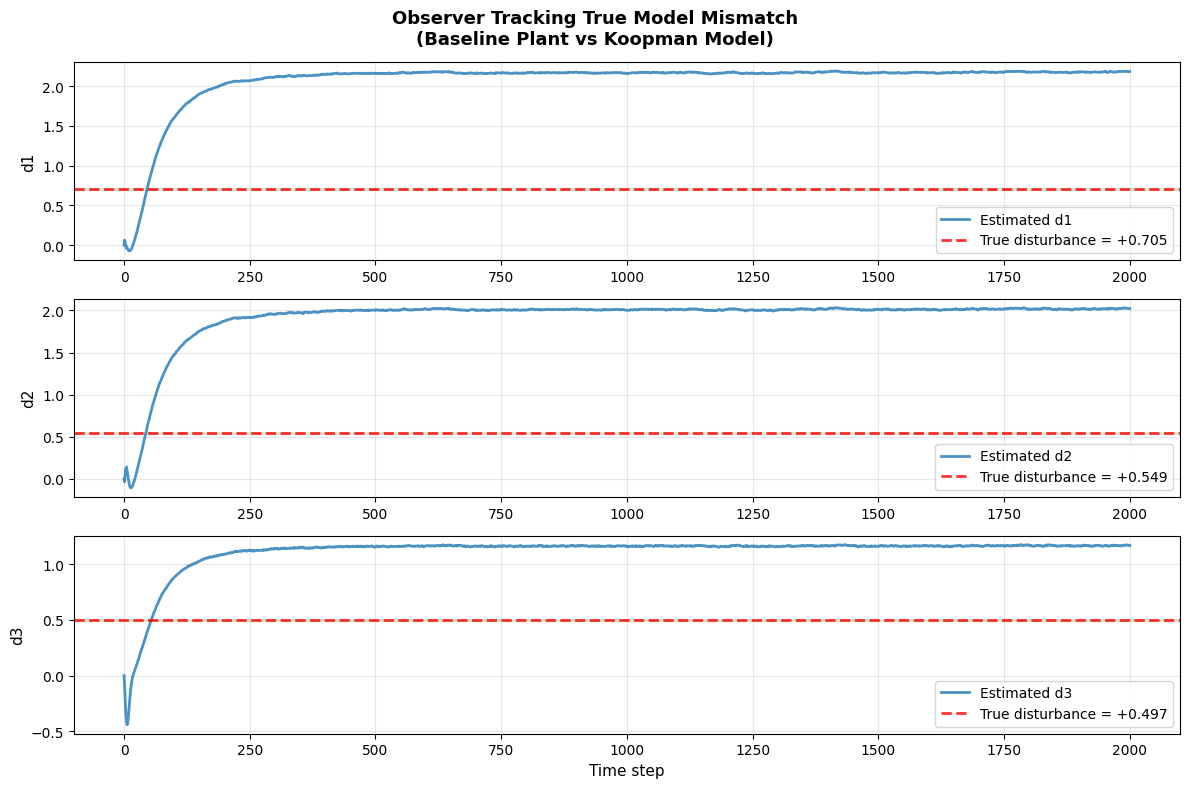


Output comparison (Baseline Plant vs Koopman Prediction):
Baseline plant output:      [1.0965474  0.62593608 0.97774765]
Koopman + est. disturbance: [3.28189296 2.64694553 2.14422259]
Prediction error:           [2.18534556 2.02100945 1.16647493]

Estimated disturbance converged to: [2.18498278 2.02166266 1.16611898]
True steady-state mismatch:         [0.70515513 0.54864836 0.49704069]

Test completed successfully!


In [140]:
# Fast test 2: Observer with constant input to baseline plant
print("="*60)
print("FAST TEST 2: Observer with Constant Input to Baseline Plant")
print("="*60)

# Verify which model is being used
print(f"\nUsing CT_10 model with matrix_C = True")
print(f"  Testing observer against real baseline plant")

# ==============================================================================
# Calculate TRUE disturbance: steady-state mismatch between baseline and Koopman
# ==============================================================================
print("\nCalculating true disturbance from steady-state mismatch...")
print("  (Using CT_10 Koopman model: A_C_True.npy, B_C_True.npy, C_C_True.npy)")

# Zero input
u_zero = np.zeros(nu)

# Baseline plant: find steady-state output with zero input
# Run baseline for many steps to reach steady state
print("  Finding baseline plant steady state (u=0)...")
baseline_inference.init()  # Reset baseline
n_ss_steps = 2000  # Steps to reach steady state
for _ in range(n_ss_steps):
    y_baseline_ss = baseline_inference.y_plus(u_zero)

print(f"  Baseline steady state (u=0): {y_baseline_ss}")

# Koopman model: steady-state with zero input
# For a stable linear system, steady state is when z[k+1] = z[k]
# So: z_ss = A @ z_ss + B @ u  =>  (I - A) @ z_ss = B @ u
# With u=0: (I - A) @ z_ss = 0  =>  z_ss = 0 (if A is stable and has no integrators)
# But we can also just simulate it
print("  Finding Koopman model steady state (u=0)...")
z_koopman_ss = np.zeros(nz)
for _ in range(n_ss_steps):
    z_koopman_ss = A @ z_koopman_ss + B @ u_zero
y_koopman_ss = C @ z_koopman_ss

print(f"  Koopman steady state (u=0):  {y_koopman_ss}")

# TRUE DISTURBANCE = baseline output - Koopman output (at zero input steady state)
true_disturbance = y_baseline_ss - y_koopman_ss

print(f"\n  TRUE DISTURBANCE (model mismatch): {true_disturbance}")
print("="*60)

# ==============================================================================
# Run test with constant (non-zero) input
# ==============================================================================
N_test2 = 2000  # Test horizon

# Initialize observer states
z_test2 = np.zeros((nz + nd, N_test2+1))
y_test2 = np.zeros((ny, N_test2+1))

# Start from a known state
# Re-initialize baseline to match a specific state
baseline_inference.init()
# Set initial state by applying the final control from main simulation a few times
for _ in range(10):
    y_init = baseline_inference.y_plus(us_sim[:, -1])

# Initial Koopman state corresponding to this output
z_test2[:nz, 0] = get_x_from_y(problem, y_init).flatten()  # Get Koopman state from output
z_test2[nz:, 0] = np.zeros(nd)    # Start with zero disturbance estimate

y_test2[:, 0] = y_init

# Constant control input (use steady-state control from main simulation)
u_const = us_sim[:, -1].copy()

# Create Kalman filter for this test
P_test2 = P0.copy()
KF_test2 = helper.KF(A_, B_, C_, z_test2[:, [0]].T, P_test2, Q, R)

print(f"\nTest setup:")
print(f"  Initial Koopman state: {z_test2[:nz, 0][:3]}...")
print(f"  Initial output: {y_test2[:, 0]}")
print(f"  Constant control input: {u_const}")
print(f"\nRunning {N_test2} steps with baseline plant...")

# Simulate with baseline plant
for k in range(N_test2):
    # Step the TRUE physical plant (baseline_inference)
    y_plant = baseline_inference.y_plus(u_const)
    
    # The plant already has the inherent model mismatch (true_disturbance)
    # No need to add it - it's already there!
    y_test2[:, k+1] = y_plant
    
    # Add small measurement noise
    noise_std = 0.002
    noise = np.random.normal(0, noise_std, size=ny)
    y_test2[:, k+1] += noise
    
    # Observer prediction and correction using standard Kalman filter
    z_test2[:, k+1] = KF_test2.step(u_const, y_test2[:, k+1]).flatten()

# Extract estimated disturbance
d_est_test2 = z_test2[nz:, :]

# Calculate convergence metrics
# NOTE: The true disturbance might differ from steady-state mismatch during transients
# but should converge to it at steady state
final_error2 = np.abs(true_disturbance - d_est_test2[:, -1])
mean_error_last_50_2 = np.mean(np.abs(true_disturbance[:, np.newaxis] - d_est_test2[:, -50:]), axis=1)

print(f"\n" + "="*60)
print("RESULTS:")
print("="*60)
print("\nTrue disturbance (steady-state model mismatch):")
print(f"  {true_disturbance}")

print("\nFinal disturbance estimation (last time step):")
for i in range(ny):
    print(f"  Output {i+1}: True={true_disturbance[i]:+.4f}, Est={d_est_test2[i, -1]:+.4f}, Error={final_error2[i]:.4f}")

print(f"\nMean error over last 50 steps:")
for i in range(ny):
    print(f"  Output {i+1}: {mean_error_last_50_2[i]:.4f}")

# Plot results
fig, axes = plt.subplots(ny, 1, figsize=(12, 8))
if ny == 1:
    axes = [axes]

for i in range(ny):
    axes[i].plot(d_est_test2[i, :], label=f'Estimated d{i+1}', linewidth=2, alpha=0.8)
    axes[i].axhline(y=true_disturbance[i], color='r', linestyle='--', linewidth=2, 
                    label=f'True disturbance = {true_disturbance[i]:+.3f}', alpha=0.8)
    axes[i].set_ylabel(f'd{i+1}', fontsize=11)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)
    
    # Add shaded convergence zone
    axes[i].axhspan(true_disturbance[i] - 0.01, true_disturbance[i] + 0.01, 
                    alpha=0.1, color='green')

axes[-1].set_xlabel('Time step', fontsize=11)
fig.suptitle('Observer Tracking True Model Mismatch\n(Baseline Plant vs Koopman Model)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare outputs: baseline plant vs Koopman model prediction
print("\n" + "="*60)
print("Output comparison (Baseline Plant vs Koopman Prediction):")
print("="*60)
y_koopman_pred = C @ z_test2[:nz, -1] + d_est_test2[:, -1]
y_baseline_actual = y_test2[:, -1]
print(f"Baseline plant output:      {y_baseline_actual}")
print(f"Koopman + est. disturbance: {y_koopman_pred}")
print(f"Prediction error:           {np.abs(y_baseline_actual - y_koopman_pred)}")
print(f"\nEstimated disturbance converged to: {d_est_test2[:, -1]}")
print(f"True steady-state mismatch:         {true_disturbance}")

print("\n" + "="*60)
print("Test completed successfully!")